# Brain Tumor Detector


#### Link to Dataset: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


## Importing Dependencies


In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
import sys
import random
import seaborn as sns

1. **`torch`**

   - Main package for PyTorch, used for performing tensor operations, training neural networks, and implementing deep learning tasks.

2. **`torch.utils.data.Dataset`**

   - A class that facilitates handling custom datasets by providing methods for accessing and processing data.

3. **`torch.utils.data.DataLoader`**

   - A utility for batching, shuffling, and parallelizing data loading during training and testing, optimizing data handling.

4. **`torch.nn`**

   - Provides foundational building blocks for creating neural networks, such as layers, loss functions, and various operations.

5. **`torch.nn.functional`**

   - Contains a set of functions for activation, loss calculations, and other operations commonly used in model implementations.

6. **`glob`**

   - Used to retrieve all pathnames matching a specific pattern, commonly employed for file operations and managing datasets.

7. **`cv2` (OpenCV)**

   - A comprehensive library for computer vision tasks, including image and video processing, manipulation, and feature extraction.

8. **`sys`**
   - Provides access to system-specific parameters and functions, often used for working with file paths, environment variables, and system-level operations.


## Reading the Dataset


### Exploring Tumor Images


In [2]:
tumor = []
path = '../Datasets/brain_tumor_dataset/yes/*.jpg'

for file in glob.iglob(path):
    img = cv2.imread(file)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

We are selecting all files with the `.jpg` extension in the `yes` folder.

The `'*'` wildcard represents selecting all files in the specified folder or directory.

- **`glob`**:

  - Finds all files matching a specific pattern (e.g., `.jpg` files).
  - `glob.iglob(path)` returns an iterator for files in the specified directory.

- **`cv2` (OpenCV)**:
  - Reads and processes images.
  - `cv2.imread(file)` loads an image from the file path in BGR (Blue, Green, Red) format for further analysis.


In [3]:
len(tumor)

154

#### Before resizing the image


(218, 180, 3) represents an image with a height of 218 pixels, a width of 180 pixels, and 3 color channels


The image dimensions are inconsistent, which is unsuitable for a machine learning model. All input images should be resized to uniform dimensions. The Dimensionality of the data should be fixed.


**All input images to a neural network should have the same dimensions**. This ensures consistency in feature extraction and allows the network to process them efficiently. Resizing or padding is commonly used to achieve uniformity.


The convention which was followed mostly was `rgb` i.e., Red, Blue, and Green


#### After resizing the image


In [4]:
for img in tumor[:5]:
    print(img.shape)

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


We resized the image to 128×128 dimensions using the `cv2.resize` function.


**`b, g, r = cv2.split(img)`**: Splits the image into its three color channels i.e., Blue, Green, and Red (BGR).

**`img = cv2.merge([r, g, b])`**: Merges the channels back in the conventional RGB order.


### Exploring healthy images


In [5]:
healthy = []
path_2 = '../Datasets/brain_tumor_dataset/no/*.jpg'

for file in glob.iglob(path_2):
    img = cv2.imread(file)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [6]:
len(healthy)

91

#### After resizing the image


In [7]:
for img in healthy[:5]:
    print(img.shape)

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


In [8]:
# Converting into Numpy Array
tumor = np.array(tumor)
healthy = np.array(healthy)

In [9]:
tumor.shape

(154, 128, 128, 3)

We have 154 datapoints. For each datapoint we have 128 rows, 128 columns and 3 channels of these rows and columns

We have 154 images having 3 channels, where each channel containing 128\*128 values


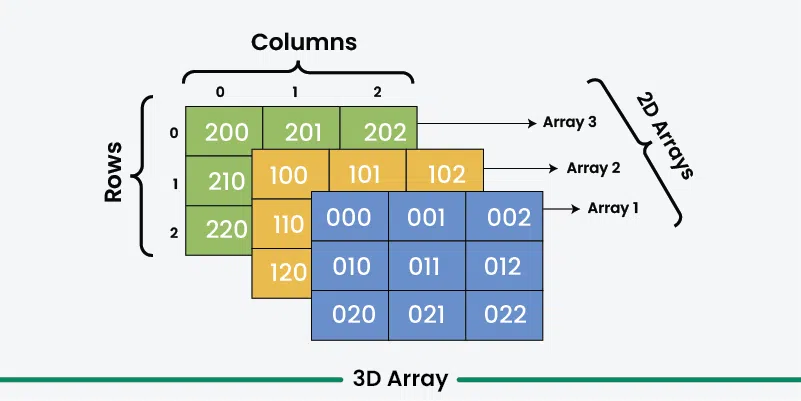


It can be clearly seen that each channel contains 128×128 rows and columns of values. (Image is for example)

The image can be represented as a 2D array with dimensions 128×128, and there are three such channels.


In [10]:
healthy.shape

(91, 128, 128, 3)

### Concatenating all the images


In [11]:
all_images = np.concatenate((healthy, tumor))

In [12]:
all_images.shape

(245, 128, 128, 3)

## Visualizing Brain MRI Images


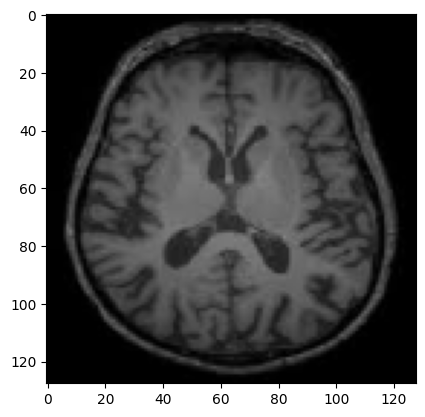

In [13]:
plt.imshow(healthy[0])

### Creating a function for random generation of Images


In [14]:
def random_gen(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16, 9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Healthy Images')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16, 9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Tumor Images')
        plt.imshow(tumor_imgs[i])

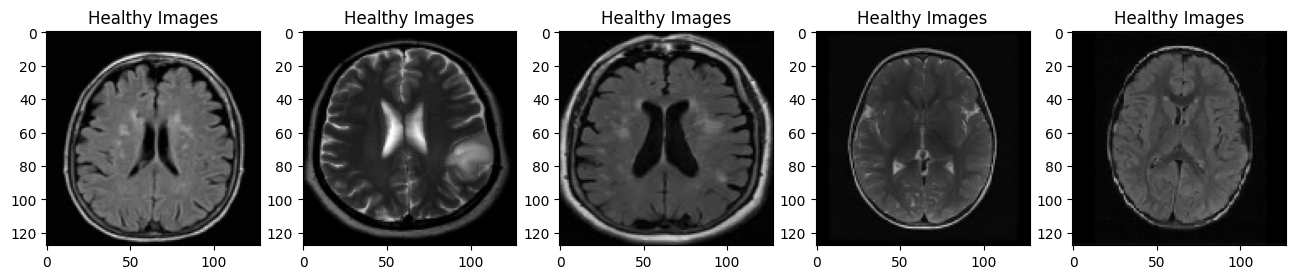

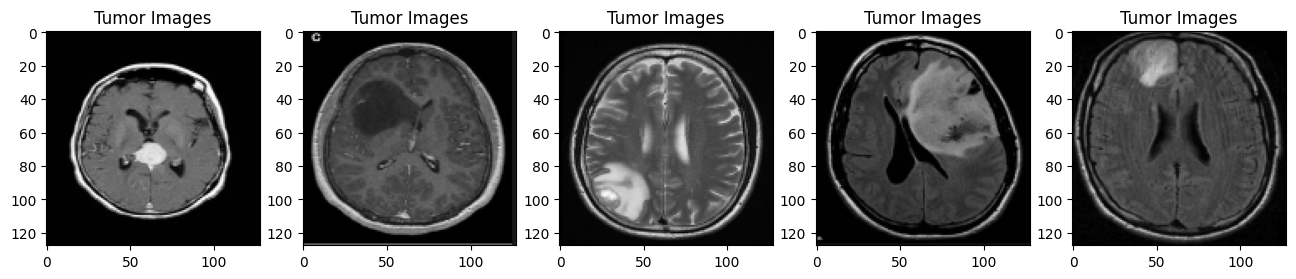

In [15]:
random_gen(healthy, tumor)

## Creating Torch Dataset Class


In [16]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

This is a Python class defining a dataset interface. Here's what each method does:

- `__getitem__(self, index)`: This method is meant to retrieve an item from the dataset at a given index. It is not implemented here, meaning subclasses must define it.
- `__len__(self)`: This method is meant to return the number of items in the dataset. It is also not implemented and must be defined in a subclass.
- `__add__(self, other)`: This method allows two datasets to be combined using the `+` operator. It returns a `ConcatDataset`, which is assumed to merge multiple datasets.

This structure is commonly used in machine learning frameworks like PyTorch, where datasets are modular and extendable.


In object-oriented programming, when creating a subclass of Dataset, you must override the **getitem** and **len** methods because they are defined as **NotImplementedError** in the base class. Without overriding them, trying to use these methods will result in an error.


In [17]:
class mri(Dataset):
    def __init__(self, score):
        self.x = score

    def __getitem__(self, index):   # Overriding the __getitem__ method defined in the base class
        return self.x[index]

    def __len__(self):    # Overriding __len__ method defined in the base class
        return len(self.x)

In [18]:
d = mri([1, 2, 3, 4])

In [19]:
d.x

[1, 2, 3, 4]

In [20]:
d[2]

3

In [21]:
len(d)

4

The key idea is to override the `__getitem__` and `__len__` methods.


Note that the parent class i.e., `Dataset` has no **Constructor method**


Any custom PyTorch dataset class must inherit from the `torch.utils.data.Dataset` abstract class.  
After inheriting, you should:

1. Define a constructor (`__init__`)
2. Override the `__len__` method
3. Override the `__getitem__` method


## Creating Custom dataset class for our MRI dataset


Datasets can be split in two ways:

1. Pre-split the data into training, validation, and test sets before passing them to the dataset class.
2. Pass the entire dataset to the class and handle the splitting internally.


We are using the second approach, where we pass the entire set into the class and separate it within the constructor.


In [22]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthy = []
        path = '../Datasets/brain_tumor_dataset/yes/*.jpg'
        path_2 = '../Datasets/brain_tumor_dataset/no/*.jpg'

        #cv2 - It reads in BGR format by default
        for file in glob.iglob(path):
            img = cv2.imread(file)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            tumor.append(img)

        for file in glob.iglob(path_2):
            img = cv2.imread(file)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            healthy.append(img)
            
        # Images
        tumor_images = np.array(tumor, dtype=np.float32)
        healthy_images = np.array(healthy, dtype=np.float32)

        # Lables
        # Tumor ---> 1
        # Healthy ---> 0
        tumor_label = np.ones(tumor_images.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy_images.shape[0], dtype=np.float32)

        # Concatenating All the Images and Labels (Seperately)
        self.images = np.concatenate((tumor_images, healthy_images), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label), axis=0)
        
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample = {'image':self.images[index], 'label':self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images/255.0

In [23]:
mri = MRI()

In [24]:
len(mri)

245

We observed that overriding the `__getitem__` method caused it to return a dictionary.


In [25]:
img = mri[5]['image']

In [26]:
img.shape

(128, 128, 3)

In [27]:
mri.normalize()   # Normalizing the values

## Creating a DataLoader


A **Dataloader** in machine learning (especially in PyTorch) efficiently loads and batches data for training and evaluation. It provides:

- **Batching**: Splits dataset into smaller batches.
- **Shuffling**: Randomizes data order to prevent model overfitting.
- **Parallel Loading**: Uses multiple workers for faster data retrieval.
- **Automatic Batching**: Converts data into tensors automatically.

Dataloaders are crucial for handling large datasets efficiently.


**PyTorch Dataloader Example**

```python
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = CustomDataset([1, 2, 3, 4, 5])
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

for batch in dataloader:
    print(batch)
```


---> Example Output
`tensor([3, 5])
tensor([1, 4])
tensor([2])`


In [28]:
dataloader = DataLoader(mri, shuffle=True, batch_size=10)

Shuffling ensures that the model doesn't learn patterns based on the order of the data, and the batch size controls how many samples are processed together during training


The extra dimension represents the batch size, which is 10 as specified.


## Model Creation


In [29]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )

        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.reshape(x.size(0), -1)  # Flattens the CNN output to a 1D Vector
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

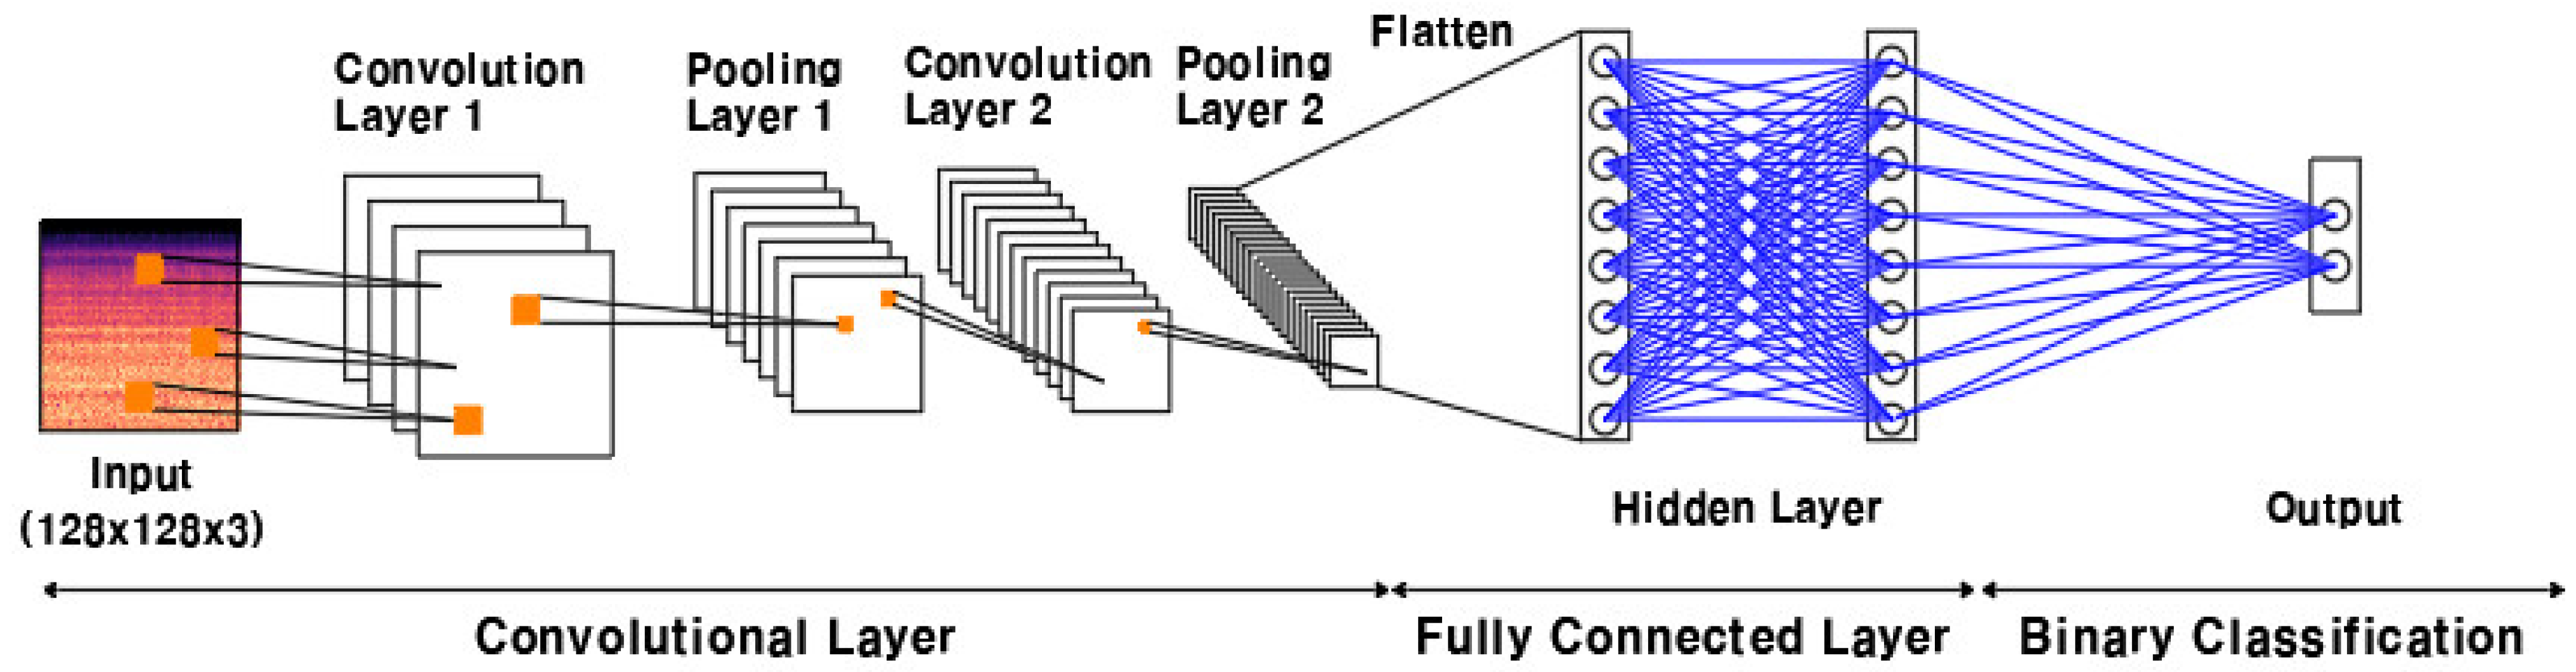


#### 1. **Class Definition and Initialization**

- The `CNN` class inherits from `nn.Module`, making it a PyTorch neural network model.
- The `__init__` method initializes the layers for feature extraction (CNN) and classification (fully connected layers).

#### 2. **Convolutional Layers (Feature Extraction)**

- The `cnn_model` consists of two convolutional layers with **Tanh** activation and **Average Pooling**.
- **First Conv Layer:**
  - Input: 3 channels (RGB image), 6 output channels, **5×5** kernel.
  - Activation: `Tanh()`.
  - Pooling: **2×2** Average Pool with a stride of 5.
- **Second Conv Layer:**
  - Input: 6 channels, 16 output channels, **5×5** kernel.
  - Activation: `Tanh()`.
  - Pooling: **2×2** Average Pool with a stride of 5.

#### 3. **Fully Connected Layers (Classification)**

- The `fc_model` consists of three fully connected (`Linear`) layers with `Tanh` activation.
- **Flattening:** Converts CNN output into a **1D vector** before passing it to the FC layers.
- **Layers:**
  - **256 → 120** neurons (Tanh).
  - **120 → 84** neurons (Tanh).
  - **84 → 1** neuron (final output).

#### 4. **Forward Pass**

- Pass input `x` through the convolutional layers.
- Flatten `x` before feeding it into the fully connected layers.
- Apply `sigmoid` activation to the final output to get a probability (for binary classification).


The nn.Tanh() function does not have learnable parameters; it applies the hyperbolic tangent activation function across all channels as a mathematical operation.


**The Logic behind the number of features**

$$
n_{out} = \text{ceil} \left[ \frac{n_{in} + 2p - f}{s} + 1 \right]
$$

Where:

1. $n_{out}$ ----> Number of output features
2. $n_{in}$ ----> Number of input features
3. p ----> Padding (Default value is Zero)
4. f ----> Size of the filter used (Kernel_size)
5. s ----> Stride (Default value is One)


The number of output channels is equal to number of filters


#### Why Does the Number of Filters Remain Unchanged After Average Pooling?

Pooling operations, such as **Average Pooling** or **Max Pooling**, reduce the spatial dimensions (**height & width**) of the feature maps but **do not change** the depth (number of channels/filters).

If the input to the pooling layer has **C** channels, the output will also have **C** channels, but with reduced width and height.

**Example:**
Suppose the input to an **average pooling layer** is:

**(32 × 32 × 64)**

- **32 × 32** → Height & Width
- **64** → Number of filters (channels)

If we apply **2×2 average pooling**, the output will be:

**(16 × 16 × 64)**

- The **spatial dimensions** are reduced by half.
- The **number of filters remains the same**.


## Parameters of the Model


In [30]:
model = CNN()

In [31]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [32]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [33]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [34]:
model.cnn_model[0].weight[0]

tensor([[[-9.1764e-02, -1.5228e-02, -2.5667e-02,  7.5797e-03, -1.0327e-01],
         [-1.1060e-01,  2.4625e-02,  7.9167e-02,  3.4275e-02, -5.3545e-02],
         [ 9.7441e-02,  3.1620e-02,  7.3290e-02,  2.7141e-02, -8.3673e-02],
         [ 2.7344e-02,  1.5009e-02,  1.1775e-02,  9.2765e-02,  9.9295e-02],
         [-7.2070e-02,  1.1454e-01, -2.9419e-02, -1.0701e-02, -3.3973e-02]],

        [[ 8.4317e-02, -3.5369e-02,  6.2500e-02, -3.0077e-02,  6.0405e-02],
         [-9.2207e-02, -6.5508e-02, -1.8907e-02, -3.1053e-02, -5.8387e-02],
         [-1.0635e-01, -3.8745e-02,  2.6781e-02,  2.9998e-02,  7.8617e-02],
         [ 5.3026e-05, -4.9414e-02,  4.2149e-02, -1.5506e-02,  1.9682e-02],
         [ 2.2713e-02, -1.0412e-01, -7.2672e-02, -1.1141e-01,  4.5302e-02]],

        [[ 1.0461e-01,  6.1686e-02,  7.6041e-02,  3.8837e-02, -1.1108e-01],
         [-9.6195e-02,  5.6177e-03,  8.7275e-02, -2.0569e-02,  1.9116e-02],
         [-8.7786e-02, -1.1039e-01, -7.1815e-02, -8.9346e-02, -7.6819e-02],
        

In [35]:
model.cnn_model[0].weight[0].shape

torch.Size([3, 5, 5])

In [36]:
model.cnn_model[0].weight.shape

torch.Size([6, 3, 5, 5])

There are a total of 6 filters, each with dimensions 5×5 and having 3 channels (depth)


Each array has a shape of **5×5**, and there are **3 arrays per set** (corresponding to the channels). In total, there are **6 such sets** (filters).


In [37]:
model.fc_model

Sequential(
  (0): Linear(in_features=256, out_features=120, bias=True)
  (1): Tanh()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): Tanh()
  (4): Linear(in_features=84, out_features=1, bias=True)
)

In [38]:
model.fc_model[0]

Linear(in_features=256, out_features=120, bias=True)

In [39]:
model.fc_model[0].weight

Parameter containing:
tensor([[-0.0258,  0.0395,  0.0406,  ..., -0.0435, -0.0042,  0.0192],
        [-0.0376,  0.0511,  0.0534,  ...,  0.0008,  0.0083, -0.0324],
        [-0.0227,  0.0203,  0.0168,  ...,  0.0604,  0.0600, -0.0505],
        ...,
        [ 0.0216,  0.0165,  0.0288,  ...,  0.0043, -0.0489,  0.0598],
        [-0.0539,  0.0228,  0.0381,  ..., -0.0353, -0.0270,  0.0225],
        [-0.0345,  0.0230,  0.0170,  ...,  0.0151, -0.0427, -0.0086]],
       requires_grad=True)

#### Understanding x.view(x.size(0), -1)


A PyTorch tensor typically has four dimensions in deep learning applications, where the first dimension represents the batch size.

In deep learning, especially for image processing using CNNs, tensors are often represented as **(Batch Size, Channels, Height, Width)**.

Example:  
For a batch of 32 RGB images of size 64×64, the tensor shape would be **(32, 3, 64, 64)**.


In [40]:
# Example
k = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [41]:
k = k.reshape((2, 2, 2, 2))

In [42]:
k

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 5,  6],
          [ 7,  8]]],


        [[[ 9, 10],
          [11, 12]],

         [[13, 14],
          [15, 16]]]])

In [43]:
k.size()

torch.Size([2, 2, 2, 2])

In [44]:
k.size(0)

2

In [45]:
k.view(-1)  # Flattened the tensor

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [46]:
k.view(k.size(0), -1)

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16]])

A clearer way to say this is:

> "There are `x.size(0)` sets, and each set should be flattened independently."

**Concept in Context of `x.view(x.size(0), -1)`**:

- `x.size(0)` represents the batch size (number of samples).
- `-1` automatically infers the remaining dimensions, flattening everything except the batch dimension.
- This ensures that each sample in the batch is flattened independently, preserving the batch structure.

For example, if `x` has shape `(32, 3, 28, 28)`, applying `x.view(x.size(0), -1)` results in `(32, 2352)`, where each of the 32 samples is now a 1D vector of size 2352(3 _ 28 _ 28).


## Training and Evaluation in PyTorch


#### model.eval()


Used particularly for Inference

1. **Batch Normalization:** During `model.eval()`, batch normalization uses the running mean and variance (computed during training) instead of the batch statistics, ensuring consistent behavior in inference.

2. **Dropout:** In `model.eval()`, dropout is disabled, meaning all neurons remain active, preventing randomness and ensuring stable predictions.

3. **Gradient Computation:** `model.eval()` does not disable gradient computation by itself, but it's often used with `torch.no_grad()` to save memory and improve inference speed.


#### model.train()


1. **Batch Normalization:** In `model.train()`, batch normalization updates running mean and variance using batch statistics, adapting to the training data distribution.

2. **Dropout:** In `model.train()`, dropout is active, randomly deactivating neurons to prevent overfitting and improve generalization.

3. **Gradient Computation:** In `model.train()`, PyTorch tracks gradients by default, enabling backpropagation for weight updates during training.


### torch.tensor vs. torch.cuda.Tensor


The key difference is that `torch.tensor` creates a tensor on the CPU by default, whereas `torch.cuda.Tensor` creates a tensor directly on the GPU, enabling faster computations.


Ensure that all tensors are on the same device (CPU or GPU) to avoid computation errors. Remember that everything is default in the CPU unless you order them to go to GPU.


In [47]:
# We can create a device and that device will be Cuda if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
# Creating a CPU Tensor
cpu_tensor = torch.rand(5)

# Converting the same to GPU Tensor
gpu_tensor = cpu_tensor.to(device)

In [49]:
print(cpu_tensor.type(), gpu_tensor.type())

torch.FloatTensor torch.FloatTensor


In [50]:
print(cpu_tensor*gpu_tensor)

tensor([0.0517, 0.7430, 0.5159, 0.4972, 0.2925])


If a GPU is unavailable, `torch.cuda.Tensor` defaults to the same type as `torch.Tensor` (CPU tensor), ensuring compatibility.


### torch.cpu().detach().numpy()


`torch.cpu().detach().numpy()` is used in PyTorch **to convert a tensor to a NumPy array**. Let's break it down step by step:

1. **`.cpu()`** – Moves the tensor to the CPU (necessary if it's on a GPU).
2. **`.detach()`** – Detaches the tensor from the computation graph, meaning no gradients will be tracked.
3. **`.numpy()`** – Converts the tensor to a NumPy array.

**Example:**

```python
import torch

# Create a tensor with requires_grad=True (tracking gradients)
tensor = torch.tensor([1.0, 2.0, 3.0], requires_grad=True, device="cuda")

# Convert to NumPy
numpy_array = tensor.cpu().detach().numpy()

print(numpy_array)  # Output: [1. 2. 3.]
```

**Why use `.detach()`?**

- If a tensor has `requires_grad=True`, directly calling `.numpy()` will raise an error because NumPy does not support autograd.

**When to use it?**

- When you want to process PyTorch tensors using NumPy.
- When you need to visualize data using `matplotlib`.
- When exporting model outputs to another system that expects NumPy arrays.


## Evaluating a New born Neural Network


We are not training the NN using any data, just we are creating a model and testing it on the available data


In [51]:
mri_dataset = MRI()
mri_dataset.normalize()

In [52]:
# Defining a Device

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 0 indicating the number of GPU, will be useful if you have more than one GPU

In [53]:
model = CNN().to(device)

# Creating a Model and sending to device to check if GPU is available

In [54]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [55]:
model.eval()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [56]:
outputs = []
y_true = []

with torch.no_grad():  # Temporarily stopping the computation of gradients
    for data in dataloader:
        image = data['image'].permute(0, 3, 1, 2).to(device)
        label = data['label'].to(device)
        y_hat = model(image)
        # This lies in GPU
        # We should convert into a Numpy Array
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

**`permute()` in PyTorch**

- **Reorders the dimensions of a tensor** without changing its data.
- Unlike `.view()`, it does **not** require the tensor to be contiguous.

**Example: Changing (H, W, C) to (C, H, W) for PyTorch**

```python
import torch

x = torch.rand(2, 3, 4)  # Shape (H, W, C)
x_permuted = x.permute(2, 0, 1)  # Shape becomes (C, H, W)

print(x.shape)         # Output: torch.Size([2, 3, 4])
print(x_permuted.shape) # Output: torch.Size([4, 2, 3])
```


In [57]:
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()
# Squeeze command gets rid of extra dimension

In [58]:
outputs.shape

(245,)

In [59]:
outputs

array([0.49014443, 0.48661262, 0.49462828, 0.494651  , 0.49286234,
       0.48837292, 0.49237293, 0.49104246, 0.48658147, 0.4919857 ,
       0.49436384, 0.48538476, 0.49143997, 0.48286533, 0.48740122,
       0.48957476, 0.49206594, 0.490277  , 0.49102682, 0.48821172,
       0.48546916, 0.4929247 , 0.4904859 , 0.49014196, 0.48523057,
       0.48665306, 0.48690546, 0.48957196, 0.49098676, 0.48887712,
       0.49267888, 0.49208134, 0.48981014, 0.49009842, 0.4882831 ,
       0.4920254 , 0.49358237, 0.48950282, 0.49436384, 0.4908186 ,
       0.49180445, 0.48991805, 0.4851562 , 0.48906025, 0.4937063 ,
       0.4904859 , 0.49014196, 0.4906763 , 0.4905285 , 0.48928368,
       0.48957196, 0.49102557, 0.49087068, 0.4920511 , 0.48946044,
       0.49176425, 0.49502754, 0.4942248 , 0.49204445, 0.49020538,
       0.49209595, 0.49556974, 0.49210414, 0.49396014, 0.4924389 ,
       0.49237767, 0.4906498 , 0.49518687, 0.4959495 , 0.493751  ,
       0.4887196 , 0.49213052, 0.49577758, 0.49266773, 0.49181

In [60]:
# We can define a simple threshold function for comparing with the true values

def threshold(scores, threshold=0.5, minimum=0, maximum=1.0):
    x = np.array(scores)
    x[x>=threshold] = maximum
    x[x<threshold] = minimum

    return x

Since we are using a Sigmoid activation function, the output value will be ranging between 0 and 1.


In [61]:
y_pred = threshold(outputs)

In [62]:
accuracy_score(y_true, y_pred)

0.37142857142857144

Remember that this accuracy is from the **untrained model**.


In [63]:
print(confusion_matrix(y_true, y_pred))

[[ 91   0]
 [154   0]]


The model was predicting everything as a tumor, which is incorrect.


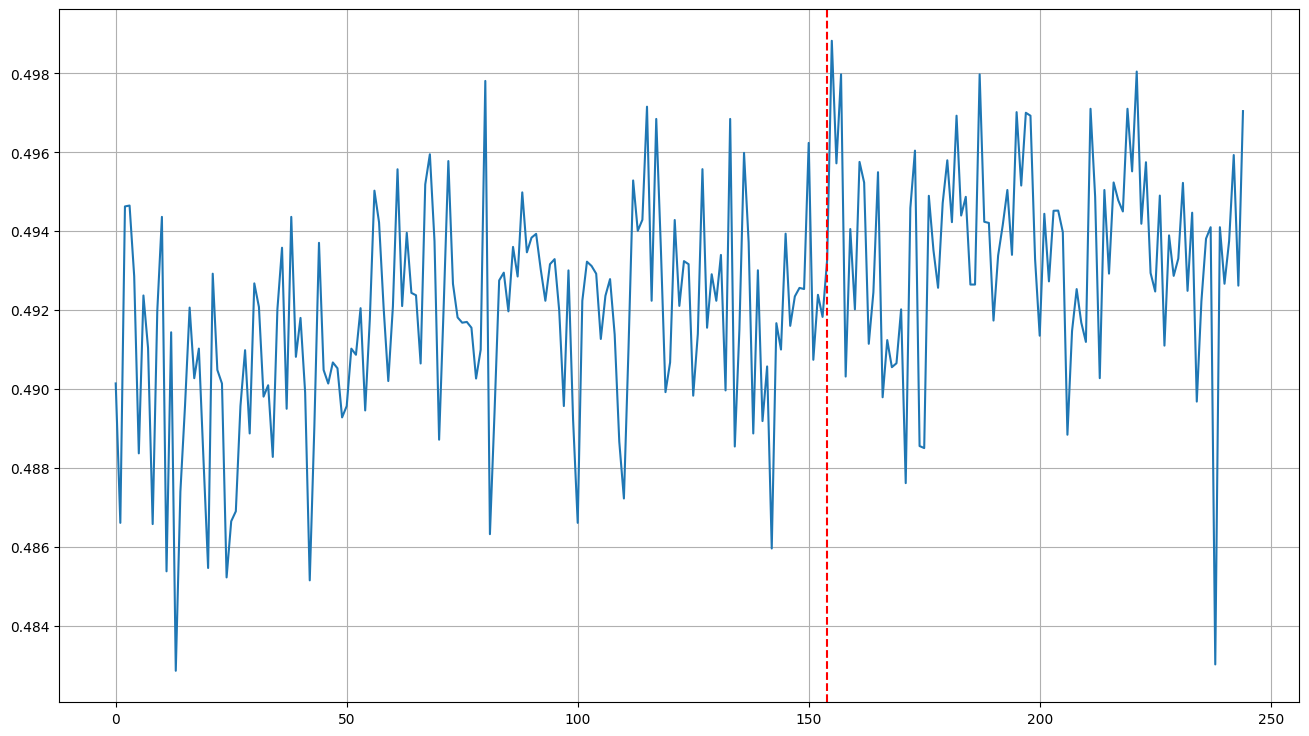

In [64]:
plt.figure(figsize=(16, 9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

## Training the Model


For training a model, we need:

1. Learning Rate
2. Optimizer
3. Data Loader
4. Loss Function
5. Device (e.g., CPU/GPU)

We will use `model.train()` to ensure dropout and batch normalization work during training.


In [65]:
alpha = 0.0001  # Learning rate
epoch = 400
optimizer = torch.optim.Adam(model.parameters(), lr=alpha)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

All learnable parameters of a model should be passed to the optimizer.

To get all the learnable parameters of a model, you can use `model.parameters()` in PyTorch or `model.trainable_variables` in TensorFlow. These methods return an iterable of all the weights and biases that can be optimized during training.

While training a machine learning model, it is generally recommended to set the `shuffle` parameter to `True`.

- This ensures that the data is randomly shuffled before each epoch, preventing the model from learning patterns based on the order of the training data.
- Shuffling helps improve the generalization of the model and reduces the risk of overfitting, as the model won't memorize the data's sequence.
- Additionally, when using stochastic or mini-batch gradient descent, shuffling helps in reducing variance during the optimization process, leading to better convergence.


In [66]:
for epoch in range(1, epoch):
    losses = []  # For keeping track of all the errors across all the epochs
    for D in dataloader:
        optimizer.zero_grad()  # Resetting the optimizer
        data = D['image'].permute(0, 3, 1, 2).to(device)
        label = D['label'].to(device)
        y_hat = model(data)  # Predicting the actual output of the model
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label)) # We are using squeeze command for making the dimensions same
        loss.backward()  # Computes Back Propagation
        optimizer.step() # Telling to update all the parameters
        losses.append(loss.item()) # item() command gets the value of tensor(We use this since loss is a tensor value)
    if (epoch+1)%10==0:  # Printing loss value for every 10 epochs
        print(f'Train epoch: {epoch+1} \t Loss: {np.mean(losses):.6f}')
        # To calculate the overall loss for an epoch, we take the mean of the individual losses of all batch points

Train epoch: 10 	 Loss: 0.621718
Train epoch: 20 	 Loss: 0.553894
Train epoch: 30 	 Loss: 0.535197
Train epoch: 40 	 Loss: 0.513823
Train epoch: 50 	 Loss: 0.504554
Train epoch: 60 	 Loss: 0.494845
Train epoch: 70 	 Loss: 0.476474
Train epoch: 80 	 Loss: 0.461332
Train epoch: 90 	 Loss: 0.442854
Train epoch: 100 	 Loss: 0.426264
Train epoch: 110 	 Loss: 0.418440
Train epoch: 120 	 Loss: 0.392850
Train epoch: 130 	 Loss: 0.383685
Train epoch: 140 	 Loss: 0.363983
Train epoch: 150 	 Loss: 0.346881
Train epoch: 160 	 Loss: 0.342590
Train epoch: 170 	 Loss: 0.318591
Train epoch: 180 	 Loss: 0.303919
Train epoch: 190 	 Loss: 0.287493
Train epoch: 200 	 Loss: 0.263566
Train epoch: 210 	 Loss: 0.256726
Train epoch: 220 	 Loss: 0.231152
Train epoch: 230 	 Loss: 0.204256
Train epoch: 240 	 Loss: 0.196324
Train epoch: 250 	 Loss: 0.181979
Train epoch: 260 	 Loss: 0.168675
Train epoch: 270 	 Loss: 0.167232
Train epoch: 280 	 Loss: 0.141422
Train epoch: 290 	 Loss: 0.134248
Train epoch: 300 	 Loss

To calculate the error, the dimensions of both the predicted values (y_hat) and the true labels should be the same.


After performing backpropagation, we calculate the gradients, which indicate how much each model parameter (like weights) needs to change to minimize the loss. These gradients are then used by the optimization algorithm to adjust the model's parameters, following its specific update rules (e.g., gradient descent). This process helps the model learn and improve its predictions over time.


`optimizer.zero_grad()` is used to clear the old gradients in PyTorch before calculating new ones during backpropagation. Gradients accumulate by default in PyTorch, so if you don’t clear them, the gradients from previous iterations will add up, leading to incorrect updates in the model's weights. Calling `zero_grad()` ensures that each update starts with fresh gradients for the current batch.


## Evaluating the Model


In [67]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].permute(0, 3, 1, 2).to(device)
        label = D['label'].to(device)
        # Predicting the values
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [68]:
accuracy_score(y_true, threshold(outputs))

1.0

In [69]:
print(confusion_matrix(y_true, threshold(outputs)))

[[ 91   0]
 [  0 154]]


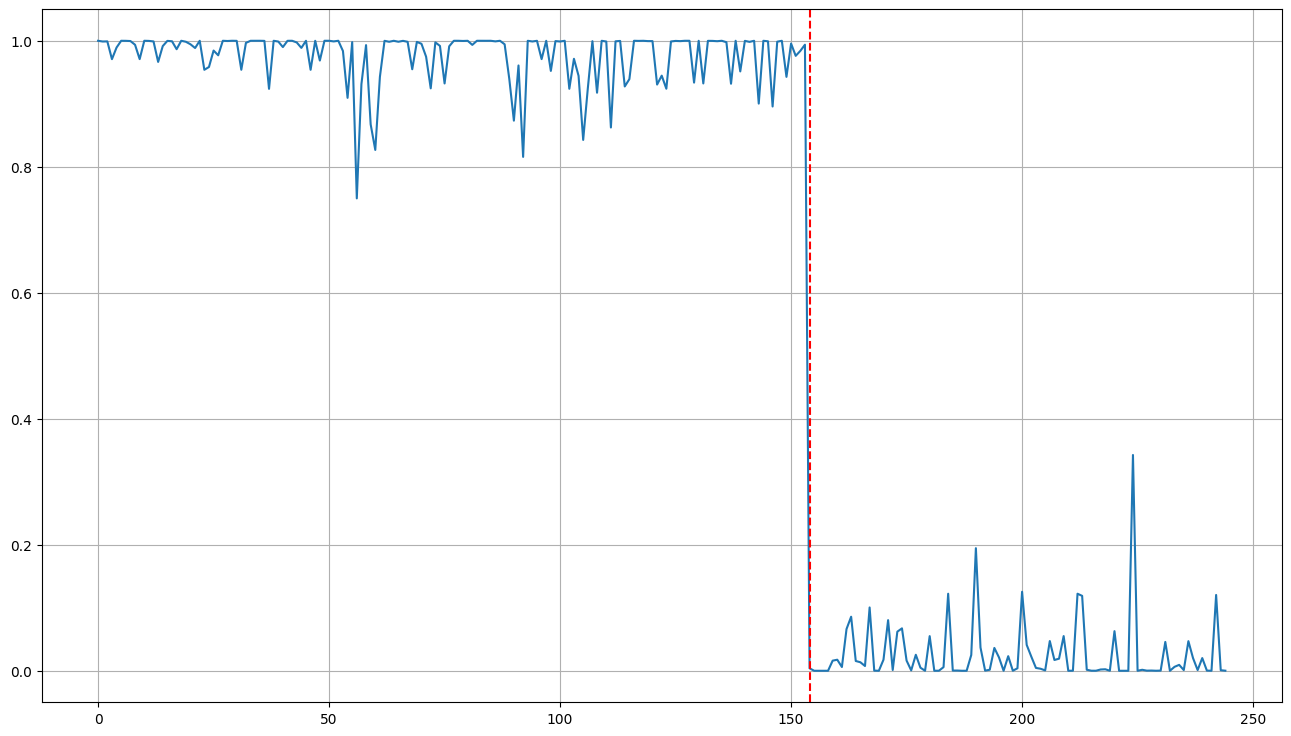

In [70]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

## Visualizing the Feature Maps of Convolutional Filters


In [71]:
no_of_layers = 0
conv_layers = []

In [72]:
# We can find all the objects of a model using the children function
model_child = list(model.children())

In [73]:
model_child  # List of two items

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [74]:
for child in model_child:
    if type(child) is nn.Sequential:
        for layer in child.children():
            if type(layer) is nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)

In [75]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

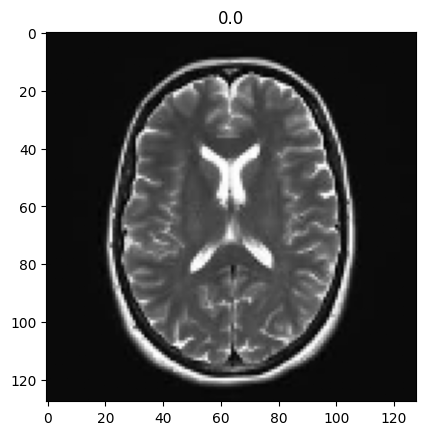

In [76]:
# Picking a random Sample Image from the Dataset
rand_int = random.randint(1, 245)
img = mri_dataset[rand_int]['image']
label = mri_dataset[rand_int]['label']
plt.title(label)
plt.imshow(img)

In [77]:
type(img)

numpy.ndarray

In [78]:
img = torch.from_numpy(img).to(device)

In [79]:
type(img)

torch.Tensor

In [80]:
img.shape

torch.Size([128, 128, 3])

In [81]:
img = img.unsqueeze(0) # Adding the dimension of the batch

We need to add the batch dimension for the image to pass into the pytorch conv layer


In [82]:
img.shape

torch.Size([1, 128, 128, 3])

In [83]:
img = img.permute(0, 3, 1, 2)

In [84]:
results = [conv_layers[0](img)]

for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))

The output of each layer serves as the input to the next layer. Since the most recent values are appended last in the array, we use `results[-1]` as the input for the $i^{th}$ layer.


In [85]:
len(results)

2

In [86]:
results[0].shape

torch.Size([1, 6, 124, 124])

In [87]:
results[1].shape

torch.Size([1, 16, 120, 120])

Layer  1


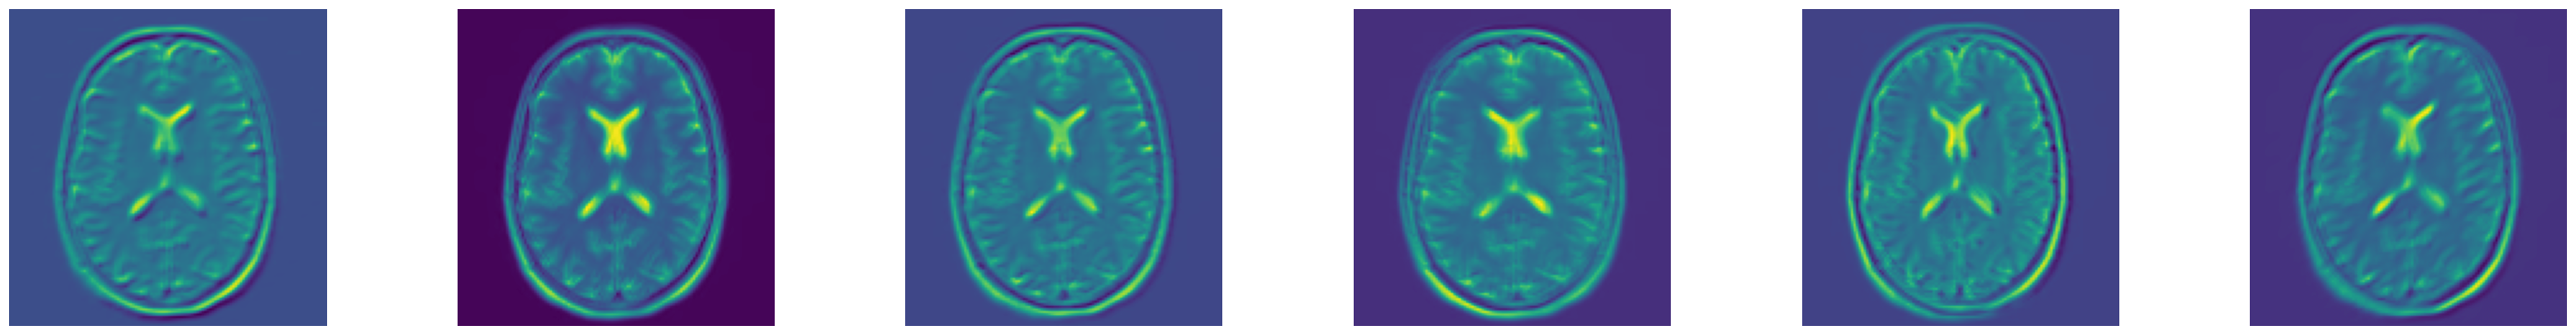

Layer  2


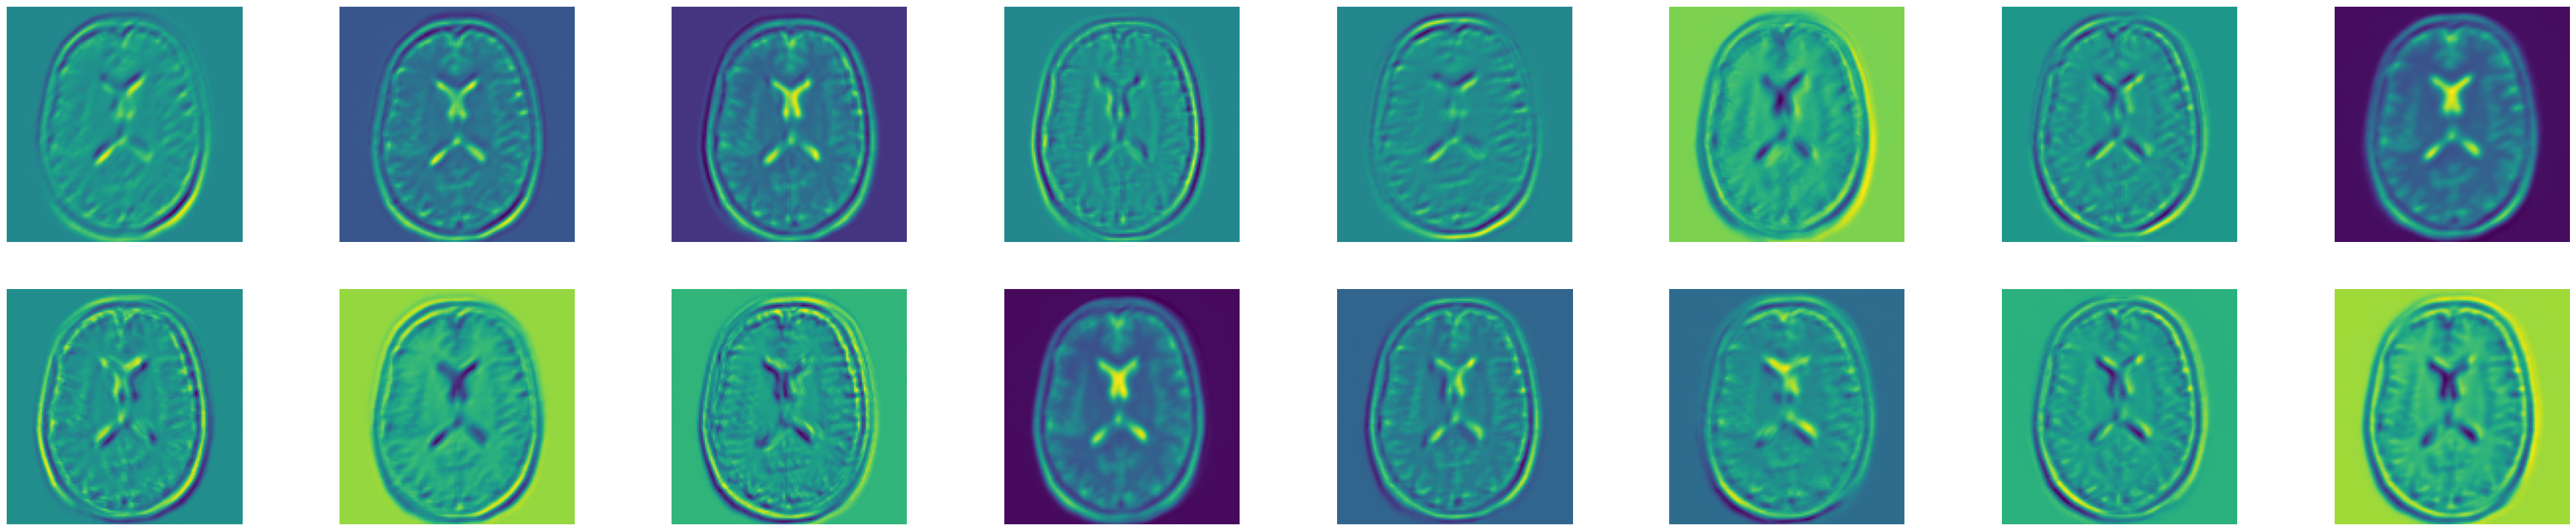

In [88]:
for num_layer in range(len(results)):
    plt.figure(figsize=(50, 10))
    layer_viz = results[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

This code visualizes feature maps (activation outputs) from different layers of a neural network.

1. **Loop Through Layers**

   - Iterates over the `results` list, where `results[num_layer]` contains feature maps from a specific layer.

2. **Create a Figure**

   - `plt.figure(figsize=(50, 10))` sets a large figure size for better visualization.

3. **Extract Feature Maps**

   - `layer_viz = results[num_layer].squeeze()` removes unnecessary dimensions to simplify the visualization.

4. **Print Layer Number**

   - Prints the current layer index (`num_layer + 1`).

5. **Loop Through Feature Maps**

   - `enumerate(layer_viz)` iterates through individual feature maps in the current layer.

6. **Plot Each Feature Map**

   - `plt.subplot(2, 8, i + 1)` arranges feature maps in a 2-row grid (assuming ≤16 maps).
   - `plt.imshow(f.detach().cpu().numpy())` converts tensors to NumPy arrays for visualization.
   - `plt.axis("off")` removes axis labels.

7. **Display and Close Plot**
   - `plt.show()` displays the visualized feature maps.
   - `plt.close()` closes the figure to free memory before moving to the next layer.


We can see the six feature maps in the first layer and the 16 feature maps in the second layer


## Preparation of Validation Set


We should create the validation set while preparing the dataset. The dataset is built using the `MRI` class, which requires some modifications.

1. Define a function to split the dataset into training and validation sets.
2. Introduce a variable called **`mode`** to specify whether we are accessing training or validation data.
3. Update the `__len__()` and `__getitem__()` methods to return data based on the selected `mode`.


In [89]:
# Import train_test_split from sklearn
# from sklearn.model_selection import train_test_split
# Imported at the start

This allows us to randomly divide the dataset into 2 sets, train and test data


Typically, the dataset is split into **80% training data** and **20% test data**. The training data is then further divided into **training and validation sets** using another split (e.g., 80-20 or 70-30). The **training set** is used to train the model, the **validation set** helps tune hyperparameters and prevent overfitting, and the **test set** evaluates final performance on unseen data.


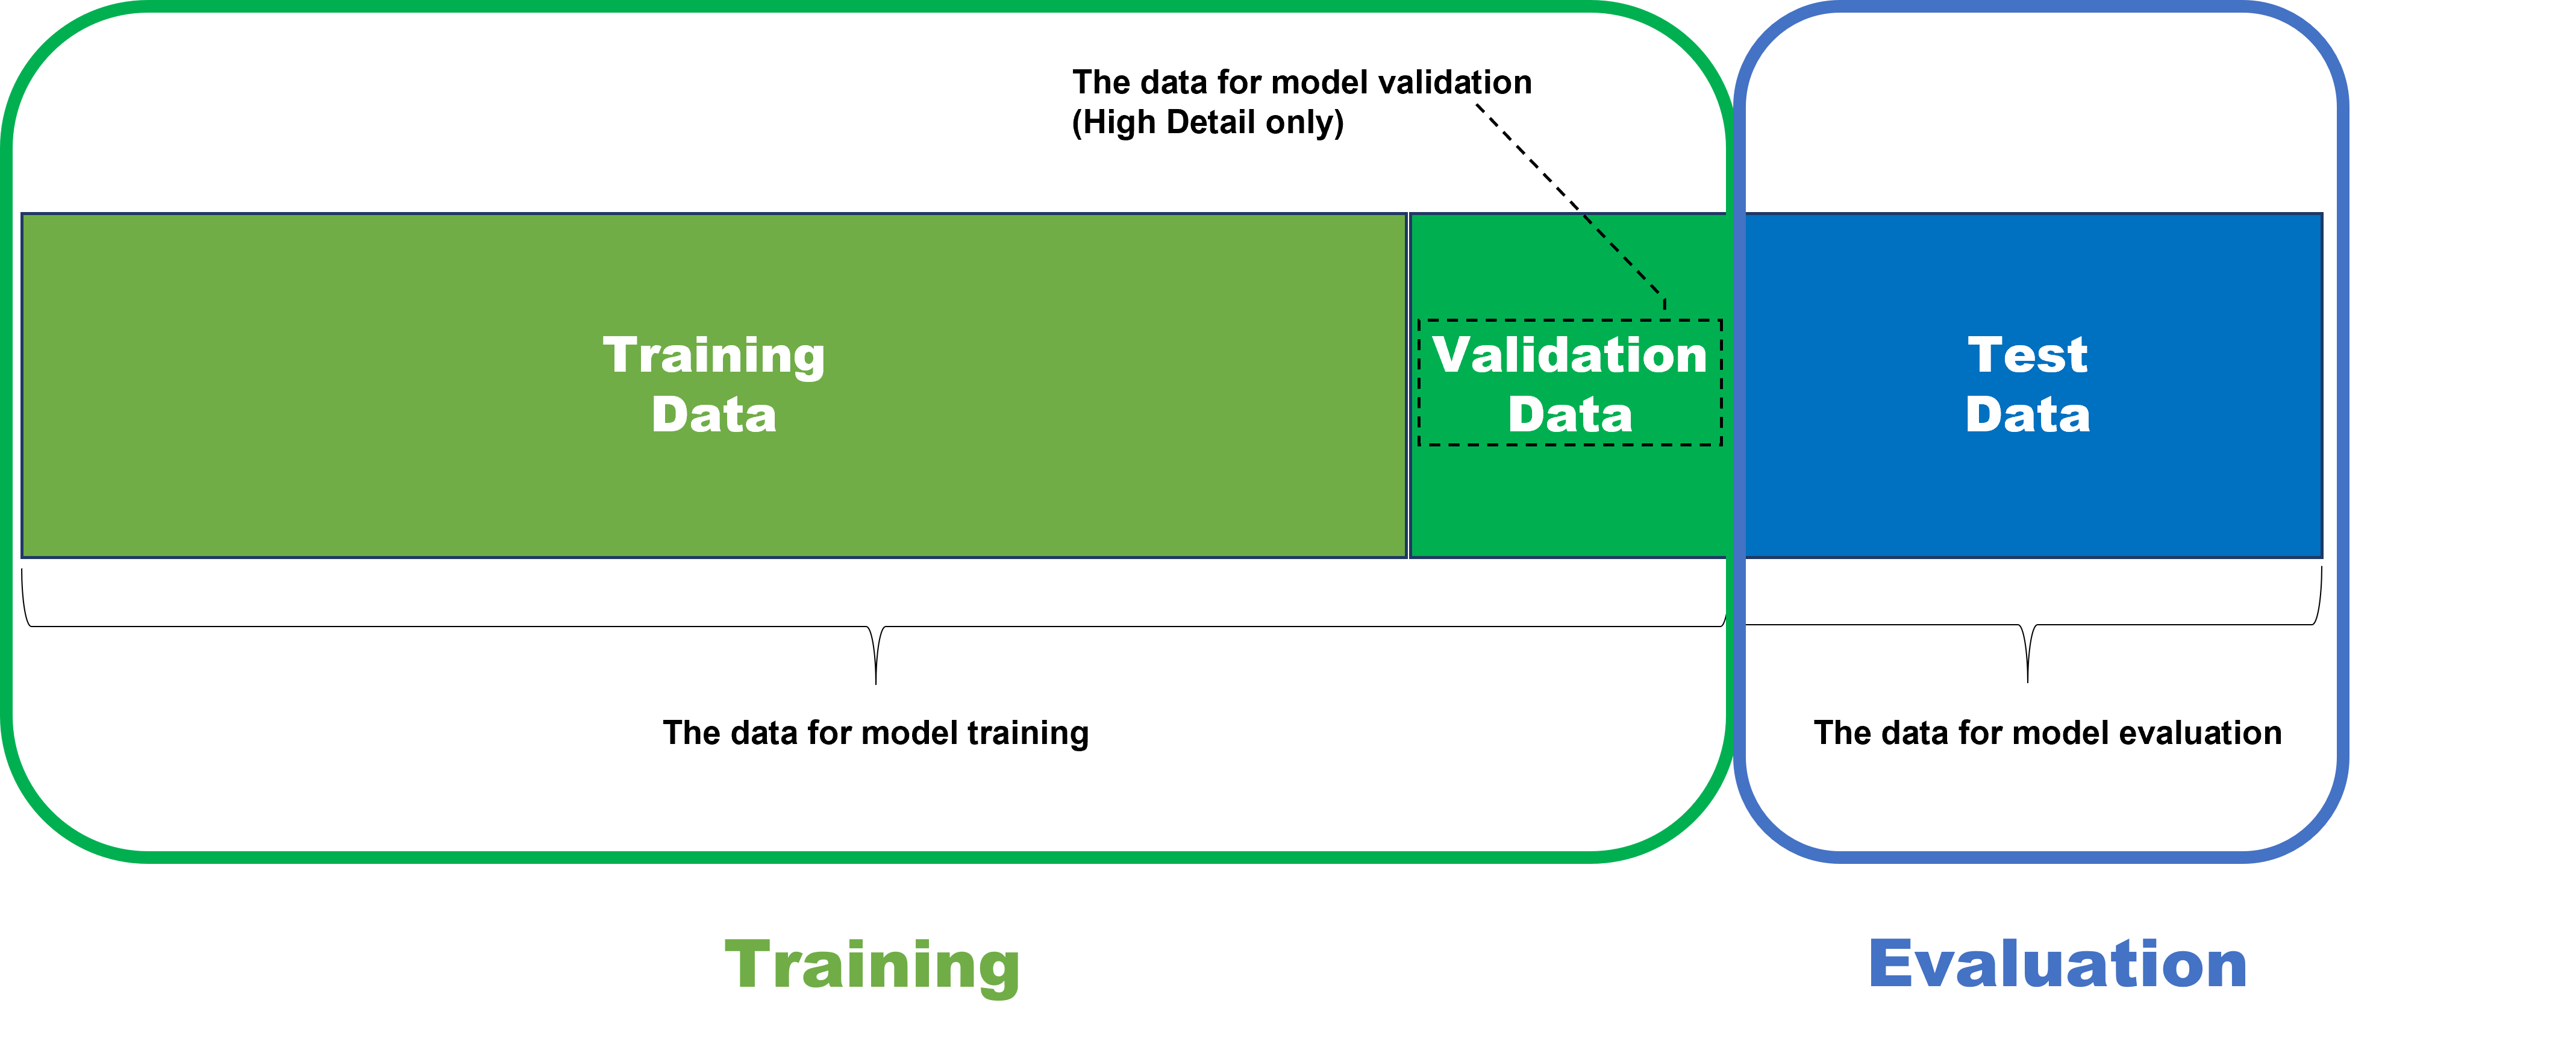


In [90]:
class MRI(Dataset):
    def __init__(self):
        # Variables for storing Training and Validation Data
        self.X_train, self.X_val, self.y_train, self.y_val = None, None, None, None

        # Variable to determine if we are interested in retrieving Training Data or Validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        path = '../Datasets/brain_tumor_dataset/yes/*.jpg'
        path_2 = '../Datasets/brain_tumor_dataset/no/*.jpg'

        #cv2 - It reads in BGR format by default
        for file in glob.iglob(path):
            img = cv2.imread(file)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            tumor.append(img)

        for file in glob.iglob(path_2):
            img = cv2.imread(file)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            healthy.append(img)
            
        # Images
        tumor_images = np.array(tumor, dtype=np.float32)
        healthy_images = np.array(healthy, dtype=np.float32)

        # Lables
        # Tumor ---> 1
        # Healthy ---> 0
        tumor_label = np.ones(tumor_images.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy_images.shape[0], dtype=np.float32)

        # Concatenating All the Images and Labels (Seperately)
        self.images = np.concatenate((tumor_images, healthy_images), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label), axis=0)

    # Function for seperating Training and Validation Data
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.images, self.labels, test_size=0.2, random_state=42)

    # Use self.mode for checking which needs to be returned
    def __len__(self):
        return self.X_train.shape[0] if self.mode == 'train' else self.X_val.shape[0]

    def __getitem__(self, index):
        if self.mode =='train':
            sample = {'image':self.X_train[index], 'label':self.y_train[index]}
        else:
            sample = {'image':self.X_val[index], 'label':self.y_val[index]}
        return sample

    def normalize(self):
        self.images = self.images/255.0

### Checking whether we are Overfitting


In [91]:
mri_data = MRI()
mri_data.normalize()
mri_data.train_val_split()

In [92]:
train_dataloader = DataLoader(mri_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_data, batch_size=32, shuffle=False)

Shuffling the dataset is crucial for training but not for validation, as validation mimics inference, where data is evaluated in its natural order.


In [93]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

In [94]:
learning_rate = 0.0001
epochs = 600
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [95]:
# For keeping track of losses
epoch_train_loss = []
epoch_val_loss = []

In [96]:
for epoch in range(1, epochs):
    train_losses = []
    model.train()
    mri_data.mode = 'train'
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].permute(0, 3, 1, 2).to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
    epoch_train_loss.append(np.mean(train_losses))

    # validate for the current epoch
    val_losses = []
    model.eval()
    mri_dataset.mode = 'val'
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].permute(0, 3, 1, 2).to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print(f'Train Epoch: {epoch+1} \t Train Loss: {np.mean(train_losses):.6f} \t Val Loss: {np.mean(val_losses):.6f}')

Train Epoch: 10 	 Train Loss: 0.622183 	 Val Loss: 0.616363
Train Epoch: 20 	 Train Loss: 0.587853 	 Val Loss: 0.566347
Train Epoch: 30 	 Train Loss: 0.531565 	 Val Loss: 0.492787
Train Epoch: 40 	 Train Loss: 0.511526 	 Val Loss: 0.468548
Train Epoch: 50 	 Train Loss: 0.489459 	 Val Loss: 0.460064
Train Epoch: 60 	 Train Loss: 0.483489 	 Val Loss: 0.451777
Train Epoch: 70 	 Train Loss: 0.451499 	 Val Loss: 0.445695
Train Epoch: 80 	 Train Loss: 0.485123 	 Val Loss: 0.435292
Train Epoch: 90 	 Train Loss: 0.435414 	 Val Loss: 0.432956
Train Epoch: 100 	 Train Loss: 0.475661 	 Val Loss: 0.425293
Train Epoch: 110 	 Train Loss: 0.487507 	 Val Loss: 0.412047
Train Epoch: 120 	 Train Loss: 0.409645 	 Val Loss: 0.408974
Train Epoch: 130 	 Train Loss: 0.419086 	 Val Loss: 0.401167
Train Epoch: 140 	 Train Loss: 0.503446 	 Val Loss: 0.404409
Train Epoch: 150 	 Train Loss: 0.438232 	 Val Loss: 0.385088
Train Epoch: 160 	 Train Loss: 0.365156 	 Val Loss: 0.368887
Train Epoch: 170 	 Train Loss: 0.

Text(0, 0.5, 'Loss')

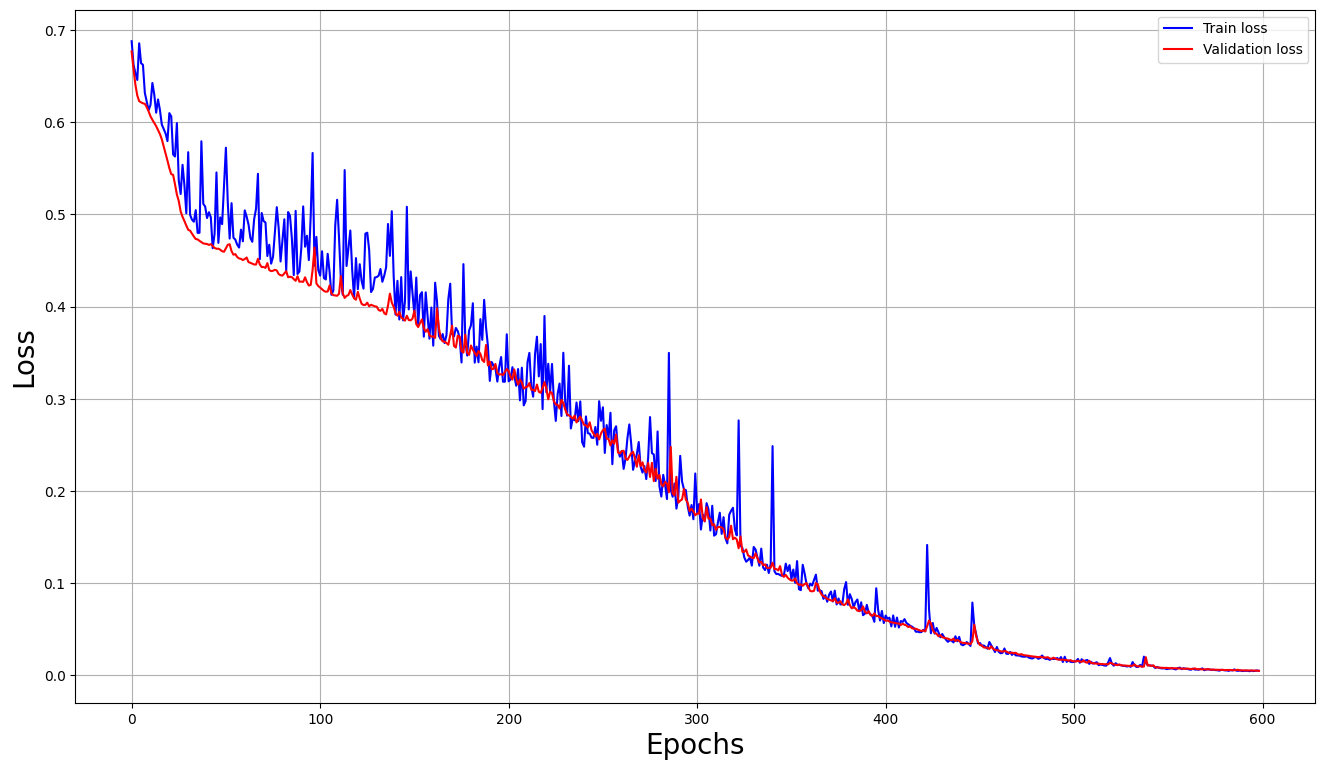

In [97]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)